In [ ]:
!pip install --upgrade sklearn
!pip install --upgrade Tensorflow

Requirement already up-to-date: sklearn in /usr/local/lib/python3.7/dist-packages (0.0)
Requirement already up-to-date: Tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)


In [ ]:
import warnings
warnings.filterwarnings('ignore') 

# Utilities
from time import time
import os, sys, six, itertools, re
import warnings, string
from ftfy import fix_encoding, fix_text, badness
sys.modules['sklearn.externals.six'] = six
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

# Numerical calculation
import numpy as np

# Data Handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#NLP
import string
import nltk
from nltk.corpus import stopwords
from nltk import tokenize
from textblob import Word
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Tools & Evaluation metrics
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, precision_score, cohen_kappa_score, confusion_matrix, f1_score, classification_report, precision_recall_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold

# Sampling technique
from sklearn.utils import resample

# Deep learning models
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input,  Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
en_ticket_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone_Project_AIML/cleaned_en_ticket.csv',encoding='utf-8')

In [ ]:
en_ticket_df.head()

,Assignment group,tokenized_desc
0,GRP_0,login issue verified user detail employee mana...
1,GRP_0,outlook team meeting skype etc appearing calen...
2,GRP_0,cannot log vpn
3,GRP_0,unable access hr tool page
4,GRP_0,unable log engineering tool skype


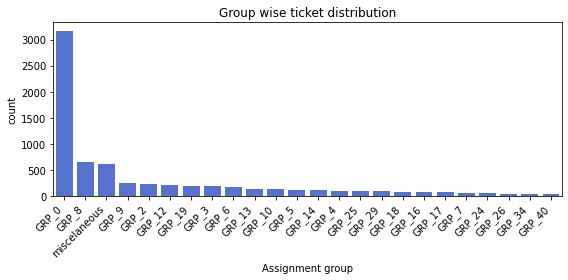

In [ ]:
descending_order = en_ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(8,4))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=en_ticket_df, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title("Group wise ticket distribution")
plt.tight_layout()
plt.show()

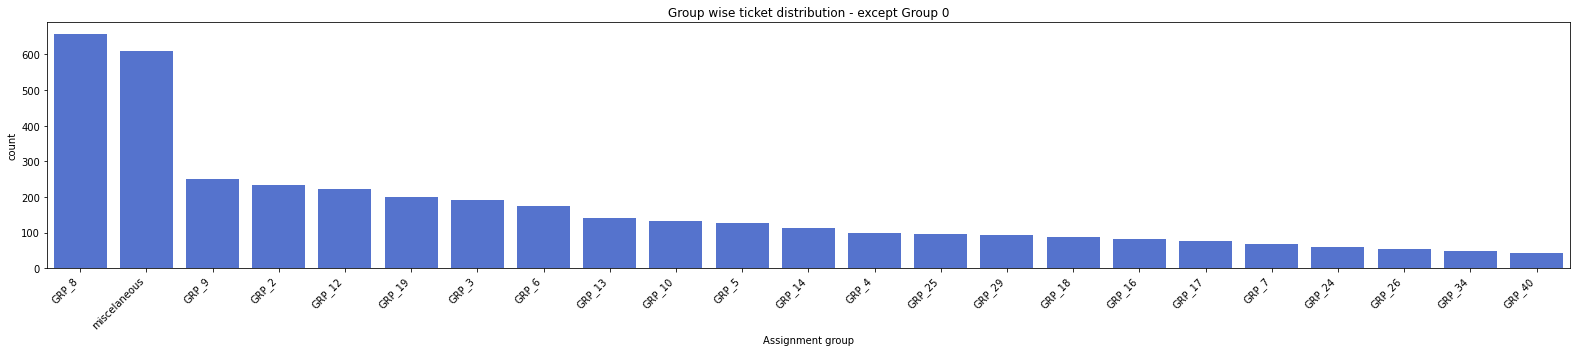

In [ ]:
#Create Dataset for 'others' i.e all groups which is not part of GRP_0
non_grp0_DF = en_ticket_df[en_ticket_df['Assignment group'] != 'GRP_0']

descending_order = non_grp0_DF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=non_grp0_DF, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title("Group wise ticket distribution - except Group 0")
plt.tight_layout()
plt.show()

In [ ]:
maxOthers = non_grp0_DF['Assignment group'].value_counts().max()
print("Maximum ticket frequency next to group 0: ", maxOthers)

Maximum ticket frequency next to group 0:  657


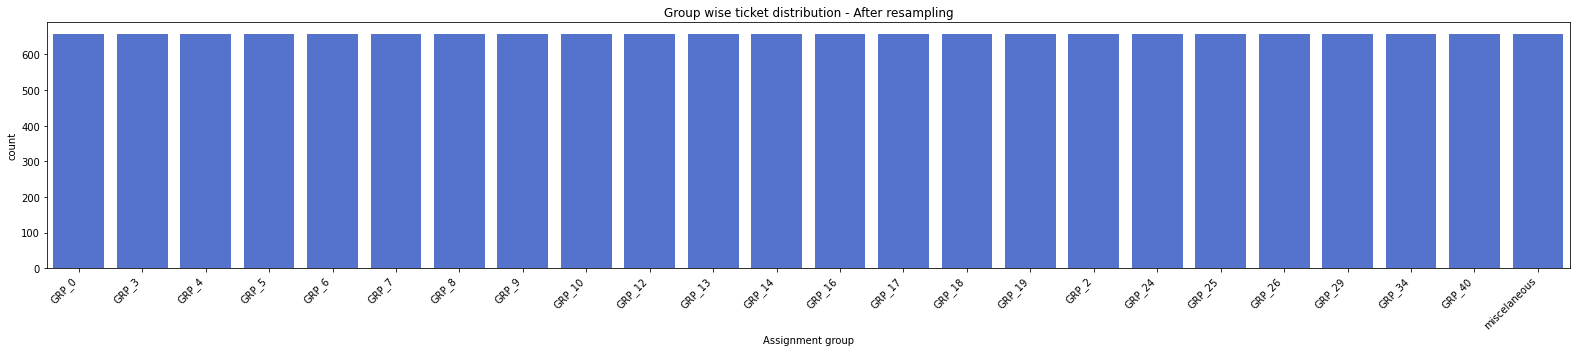

In [ ]:
# Resampling to 657
resampled_df = en_ticket_df[0:0]
for grp in en_ticket_df['Assignment group'].unique():
    itTicketGrpDF = en_ticket_df[en_ticket_df['Assignment group'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers), random_state=123)
    resampled_df = resampled_df.append(resampled)

descending_order = resampled_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=resampled_df, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title("Group wise ticket distribution - After resampling")
plt.tight_layout()
plt.show()

In [ ]:
def labelencoder(dataframe) : 
  label_encoder = preprocessing.LabelEncoder() 
  dataframe= label_encoder.fit_transform(dataframe)
  return dataframe

resampled_df['Assignment group']= labelencoder(resampled_df['Assignment group'])
en_ticket_df['Assignment group'] = labelencoder(en_ticket_df['Assignment group'])

In [ ]:
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D,GRU,Conv1D,MaxPooling1D
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Add Function to capture results from each model 
import operator
def captureData(dataframe,modelHistory,modelName,index_df,resetData):
  if resetData == 1:
    tempResultsDf=pd.DataFrame()
    dataframe=pd.DataFrame()
  else:
    index, acc_value = max(enumerate(modelHistory.history['val_accuracy']), key=operator.itemgetter(1))
    tempResultsDf= pd.DataFrame(
      {'model':[modelName], 
      'val_accuracy': [acc_value],
      'val_loss':[modelHistory.history['val_loss'][index]],
      'loss':[modelHistory.history['loss'][index]],
      'accuracy':[modelHistory.history['accuracy'][index]]},index={str(index_df)})
    dataframe = pd.concat([dataframe,tempResultsDf])
    dataframe = dataframe[['model','val_accuracy' ,'val_loss','loss','accuracy']] 
  return dataframe


## **Word2Vec embedding LSTM**

In [ ]:
project_path =  ('/content/drive/My Drive/Colab Notebooks/Capstone_Project_AIML/')
sentences = [line.split(' ') for line in en_ticket_df['tokenized_desc']]
word2vec = Word2Vec(sentences=sentences,min_count=1)
word2vec.wv.save_word2vec_format(project_path+ 'word2vec_vector.txt')

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(project_path+'word2vec_vector.txt')

for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 10005 word vectors.


In [ ]:
maxlen = 300
numWords=9668
epochs = 10

results=pd.DataFrame()
pred_results = pd.DataFrame()

In [ ]:
class LstmModel:
  model= Model()
  X_test=[]
  y_test=[]
  embedding_matrix=[]

  def wordTokenizer(self, dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe
  
  def splitData(self,X,y):

    print("Number of Samples:", len(X))
    print("Number of Labels: ", len(y))
    X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=10) # changed by Abraham
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=10)
    print("Number of train Samples:", len(X_train))
    print("Number of val Samples:", len(X_Val))

    return X_train, self.X_test, y_train, self.y_test, X_Val, y_Val

  def tokenizeAndEmbedding(self,dataframe):
    
    tokenizer,X = self.wordTokenizer(dataframe['tokenized_desc'])
    y = np.asarray(dataframe['Assignment group'])
    X = pad_sequences(X, maxlen = maxlen)

    self.embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer.index_word.items():
      if i<numWords+1:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            self.embedding_matrix[i] = embedding_vector
    return X,y

  def train(self, dataframe, batch_size, epochs):
   
    X,y = self.tokenizeAndEmbedding(dataframe)
    X_train, _, y_train, _, X_Val, y_Val = self.splitData(X,y)
    model_history = self.fitModel(X_train,y_train,X_Val,y_Val,batch_size, epochs)
    return model_history

  def fitModel(self,X_train,y_train,X_Val,y_Val,batch_size, epochs):
    
    input_layer = Input(shape=(maxlen,),dtype=tf.int64)
    embed = Embedding(numWords+1,output_dim=100,input_length=maxlen,weights=[self.embedding_matrix], trainable=True)(input_layer)  #weights=[embedding_matrix]
    lstm=Bidirectional(LSTM(128))(embed)
    drop=Dropout(0.3)(lstm)
    dense =Dense(100,activation='relu')(drop)
    out=Dense(len((pd.Series(y_train)).unique()),activation='softmax')(dense)   

    self.model = Model(input_layer,out)
    self.model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    self.model.summary()
    plot_model(self.model,to_file="LSTM_Model.jpg")

    checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
    reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
    model_history = self.model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val,y_Val))

    return model_history,self.model

  def plotModelAccuracy(self, history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [ ]:
# Check how the LSTM Model perform with the cleansed data
lstmModelRawData = LstmModel()
lstmModelRawData_history, model = lstmModelRawData.train(en_ticket_df,100,epochs)

Number of Samples: 7036
Number of Labels:  7036
Number of train Samples: 5628
Number of val Samples: 1408
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 100)          966900    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               25700     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                2424      
Total params: 1,229

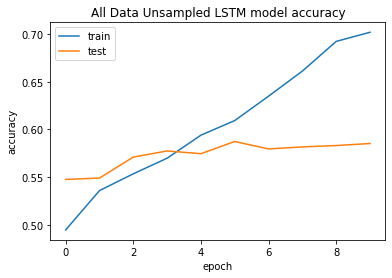

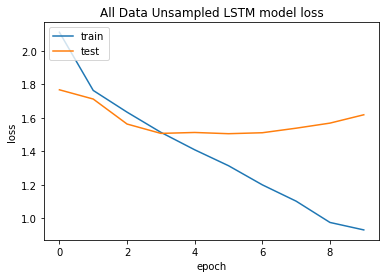

In [ ]:
lstmModelRawData.plotModelAccuracy(lstmModelRawData_history, 'All Data Unsampled LSTM')

In [ ]:
# Check how the LSTM Model perform with all the data which is cleansed & resampled to 661 to make the target balance
lstmModelAllDataResampled = LstmModel()
lstmModelAllDataResampled_history, model = lstmModelAllDataResampled.train(resampled_df,100,epochs)

Number of Samples: 15768
Number of Labels:  15768
Number of train Samples: 12614
Number of val Samples: 3154
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 100)          966900    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_3 (Dense)              (None, 24)                2424      
Total params: 1,

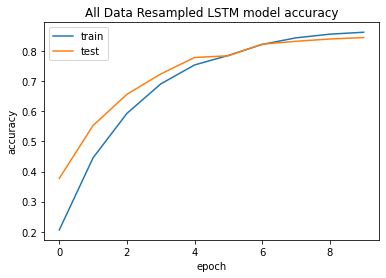

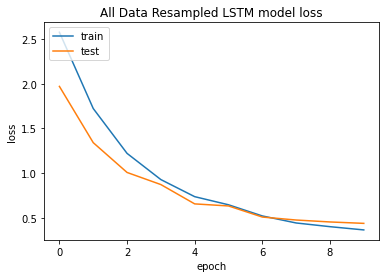

In [ ]:
lstmModelAllDataResampled.plotModelAccuracy(lstmModelAllDataResampled_history, 'All Data Resampled LSTM')

In [ ]:
results=pd.DataFrame()
pred_results = pd.DataFrame()

In [ ]:
results=captureData(results,lstmModelRawData_history,'LSTM model_WV_rawdata','1',0)
results=captureData(results,lstmModelAllDataResampled_history,'LSTM model_WV_resampled data','2',0)

In [ ]:
results

,model,val_accuracy,val_loss,loss,accuracy
1,LSTM model_WV_rawdata,0.587358,1.505744,1.314803,0.609275
2,LSTM model_WV_resampled data,0.845593,0.437789,0.364464,0.863326


## **GloVe Embedding LSTM**

In [ ]:
# EMBEDDING_FILE = './glove.6B.200d.txt'
EMBEDDING_FILE = project_path+ './glove.6B.100d.txt'
embeddings_glove = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    #print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    #print(embd)
    embeddings_glove[word] = embd

In [ ]:
print("Dimension of the embedding vector is {}".format(len(embeddings_glove["collaboration"])))
print("Dimension of the embedding vector is {}".format(len(embeddings_glove["platform"])))

Dimension of the embedding vector is 100
Dimension of the embedding vector is 100


In [ ]:
class LstmGloveModel:
  model= Model()
  X_test=[]
  y_test=[]
  embedding_matrix=[]

  def wordTokenizer(self, dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe
  
  def splitData(self,X,y):

    print("Number of Samples:", len(X))
    print("Number of Labels: ", len(y))
    X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=10) # changed by Abraham
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=10)
    print("Number of train Samples:", len(X_train))
    print("Number of val Samples:", len(X_Val))

    return X_train, self.X_test, y_train, self.y_test, X_Val, y_Val

  def tokenizeAndEmbedding(self,dataframe):
    
    tokenizer,X = self.wordTokenizer(dataframe['tokenized_desc'])
    y = np.asarray(dataframe['Assignment group'])
    X = pad_sequences(X, maxlen = maxlen)

    self.embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer.index_word.items():
      if i<numWords+1:
        embedding_vector = embeddings_glove.get(word)
        if embedding_vector is not None:
            self.embedding_matrix[i] = embedding_vector
    return X,y

  def train(self, dataframe, batch_size, epochs):
   
    X,y = self.tokenizeAndEmbedding(dataframe)
    X_train, _, y_train, _, X_Val, y_Val = self.splitData(X,y)
    model_history = self.fitModel(X_train,y_train,X_Val,y_Val,batch_size, epochs)
    return model_history

  def fitModel(self,X_train,y_train,X_Val,y_Val,batch_size, epochs):
    
    input_layer = Input(shape=(maxlen,),dtype=tf.int64)
    embed = Embedding(numWords+1,output_dim=100,input_length=maxlen,weights=[self.embedding_matrix], trainable=True)(input_layer)  #weights=[embedding_matrix]
    lstm=Bidirectional(LSTM(128))(embed)
    drop=Dropout(0.3)(lstm)
    dense =Dense(100,activation='relu')(drop)
    out=Dense(len((pd.Series(y_train)).unique()),activation='softmax')(dense)   

    self.model = Model(input_layer,out)
    self.model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
    reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
    model_history = self.model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val,y_Val))
    return model_history,self.model

  def plotModelAccuracy(self, history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [ ]:
lstmModelRawData = LstmGloveModel()
lstmModelRawData_history, model = lstmModelRawData.train(en_ticket_df,100,epochs)

Number of Samples: 7036
Number of Labels:  7036
Number of train Samples: 5628
Number of val Samples: 1408
Epoch 1/10
57/57 [==============================] - 108s 2s/step - loss: 2.2672 - accuracy: 0.4661 - val_loss: 1.8130 - val_accuracy: 0.5405

Epoch 00001: val_accuracy improved from -inf to 0.54048, saving model to model-001-0.540483.h5
Epoch 2/10
57/57 [==============================] - 101s 2s/step - loss: 1.7519 - accuracy: 0.5398 - val_loss: 1.5879 - val_accuracy: 0.5675

Epoch 00002: val_accuracy improved from 0.54048 to 0.56747, saving model to model-002-0.567472.h5
Epoch 3/10
57/57 [==============================] - 101s 2s/step - loss: 1.5313 - accuracy: 0.5633 - val_loss: 1.5020 - val_accuracy: 0.5582

Epoch 00003: val_accuracy did not improve from 0.56747
Epoch 4/10
57/57 [==============================] - 101s 2s/step - loss: 1.3621 - accuracy: 0.5943 - val_loss: 1.4775 - val_accuracy: 0.5689

Epoch 00004: val_accuracy improved from 0.56747 to 0.56889, saving model to mo

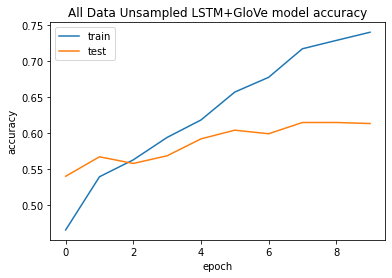

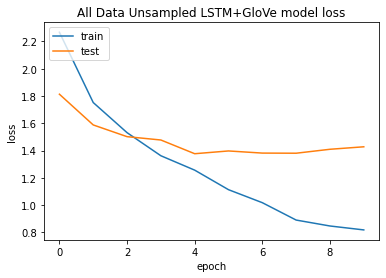

In [ ]:
lstmModelRawData.plotModelAccuracy(lstmModelRawData_history, 'All Data Unsampled LSTM+GloVe')

In [ ]:
#Check how the LSTM Model perform with all the data which is cleansed & resampled to 661 to make the target balance
lstmModelAllDataResampled = LstmGloveModel()
lstmModelAllDataResampled_history, model = lstmModelAllDataResampled.train(resampled_df,100,epochs)

Number of Samples: 15768
Number of Labels:  15768
Number of train Samples: 12614
Number of val Samples: 3154
Epoch 1/10
127/127 [==============================] - 232s 2s/step - loss: 2.3379 - accuracy: 0.3033 - val_loss: 1.5386 - val_accuracy: 0.5063

Epoch 00001: val_accuracy improved from -inf to 0.50634, saving model to model-001-0.506341.h5
Epoch 2/10
127/127 [==============================] - 227s 2s/step - loss: 1.2724 - accuracy: 0.5936 - val_loss: 1.0112 - val_accuracy: 0.6684

Epoch 00002: val_accuracy improved from 0.50634 to 0.66836, saving model to model-002-0.668358.h5
Epoch 3/10
127/127 [==============================] - 227s 2s/step - loss: 0.8759 - accuracy: 0.7054 - val_loss: 0.7664 - val_accuracy: 0.7422

Epoch 00003: val_accuracy improved from 0.66836 to 0.74223, saving model to model-003-0.742232.h5
Epoch 4/10
127/127 [==============================] - 226s 2s/step - loss: 0.6922 - accuracy: 0.7650 - val_loss: 0.6758 - val_accuracy: 0.7755

Epoch 00004: val_accurac

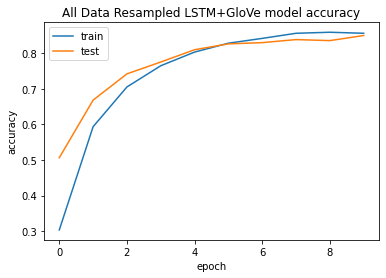

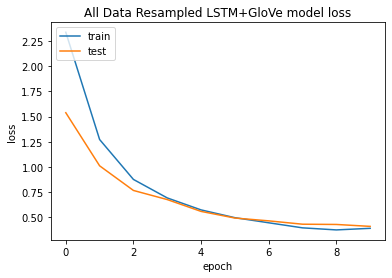

In [ ]:
lstmModelAllDataResampled.plotModelAccuracy(lstmModelAllDataResampled_history, 'All Data Resampled LSTM+GloVe')

In [ ]:
results=captureData(results,lstmModelRawData_history,'LSTM model_GloVe_rawdata','5',0)
results=captureData(results,lstmModelAllDataResampled_history,'LSTM model_GloVe_resampled data','6',0)

In [ ]:
results.sort_values(by='val_accuracy', ascending = False, ignore_index = True)

,model,val_accuracy,val_loss,loss,accuracy
0,LSTM model_GloVe_resampled data,0.850032,0.409629,0.390358,0.856350
1,LSTM model_WV_resampled data,0.845593,0.437789,0.364464,0.863326
2,LSTM model_GloVe_rawdata,0.615057,1.380631,0.890840,0.717306
3,LSTM model_WV_rawdata,0.587358,1.505744,1.314803,0.609275
